classes: 0-cy, 1-en, 2-ga, 3-gd
484        arhoswch gwaeddodd
1539      tuirtin righeamhuil
1841               don aimsir
1873    conchubhar máighistir
1961               right yeah
2605          duilluir spuinc
3633       mionghearraigh iad
3917     chachachachailleas é
5167       genitive preucháin
5317       imtheachta aeniasa
Name: 0, dtype: object
(9928, 10264)


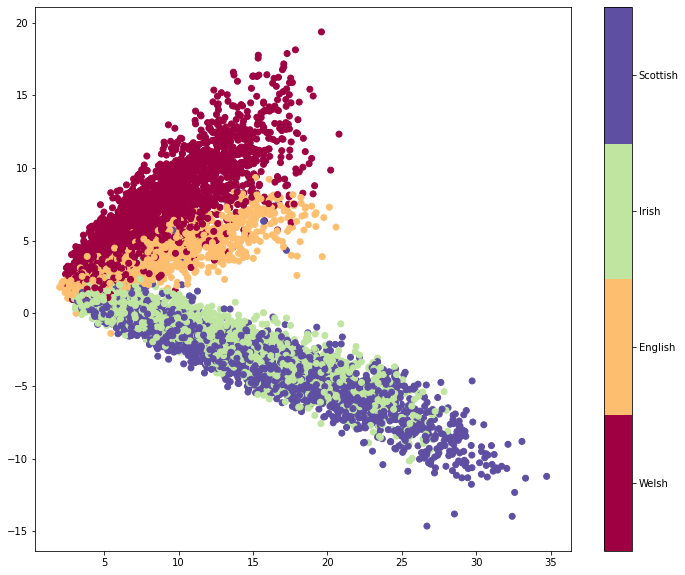

In [2]:
from sklearn.cluster import Birch, AgglomerativeClustering
from matplotlib import pyplot
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import FunctionTransformer

consonants = list("bcdfghjklmnpqrstvwxzŵ")


class AverageWordLengthExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def average_word_length(self, sent):
        return np.mean([len(word) for word in sent.split()])

    def transform(self, df, y=None):
        return pd.DataFrame(df.apply(self.average_word_length))

    def fit(self, df, y=None):
        return self


class CountConsonantsExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def consonants_count(self, sent):
        return sum(word.count(c) for c in consonants for word in sent.split()) / len(sent.split())

    def transform(self, df, y=None):
        return pd.DataFrame(df.apply(self.consonants_count))

    def fit(self, df, y=None):
        return self


class CountLetterExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, letter):
        self.letter = letter

    def letter_count(self, sent):
        return sent.count(self.letter) / len(sent.split())

    def transform(self, df, y=None):
        return pd.DataFrame(df.apply(self.letter_count))

    def fit(self, df, y=None):
        return self

def get_data():
    file = "./data/1preproc.tsv"
    data_all = pd.read_csv(file, sep='\t', header=None, quoting=3, error_bad_lines=False)
    data_all[0] = data_all[0].astype(str)

    data = data_all.iloc[:, 0]
    target = data_all.iloc[:, 1]

    target = target.astype("category").cat.codes

    split = 0.8
    n = int(len(data) * split)
    train_data = data[:n]
    train_target = target[:n]
    test_data = data[n:]
    test_target = target[n:]

    print("classes: 0-cy, 1-en, 2-ga, 3-gd")

    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(train_data[train_data.str.split().str.len().lt(3)])

    return train_data, train_target, test_data, test_target, data, target

def print_cm(test_target, y_pred):
    ax = plt.subplot()
    sns.heatmap(confusion_matrix(test_target, y_pred), annot=True, cmap='Spectral', fmt='g')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.xaxis.set_ticklabels(["Welsh", "English", "Irish", "Scottish"])
    ax.yaxis.set_ticklabels(["Welsh", "English", "Irish", "Scottish"])
    plt.show()

train_data, train_target, test_data, test_target, texts, full_target = get_data()

NGRAM_MIN = 2
NGRAM_MAX = 3
analyzer = 'char_wb'

features = FeatureUnion([('ave', AverageWordLengthExtractor()),
                                ('cons', CountConsonantsExtractor()),
                                 ('vect', CountVectorizer(ngram_range=(NGRAM_MIN, NGRAM_MAX), analyzer=analyzer))
                                ])

feats = features.fit_transform(texts)
print(feats.shape)

from sklearn.decomposition import TruncatedSVD
pca = TruncatedSVD(n_components=2).fit(feats)
data2D = pca.transform(feats)

#Plot stat data 2D
plt.figure(figsize=(12, 10))
plt.scatter(data2D[:, 0], data2D[:, 1], cmap=plt.cm.get_cmap('Spectral', 4), c=full_target)
cbar = plt.colorbar()
cbar.set_ticks([0.375, 1.125, 1.875, 2.625])
cbar.set_ticklabels(["Welsh", "English", "Irish", "Scottish"])


In [3]:
pca_500comp = TruncatedSVD(n_components=500).fit(feats)
data500D = pca_500comp.transform(feats)

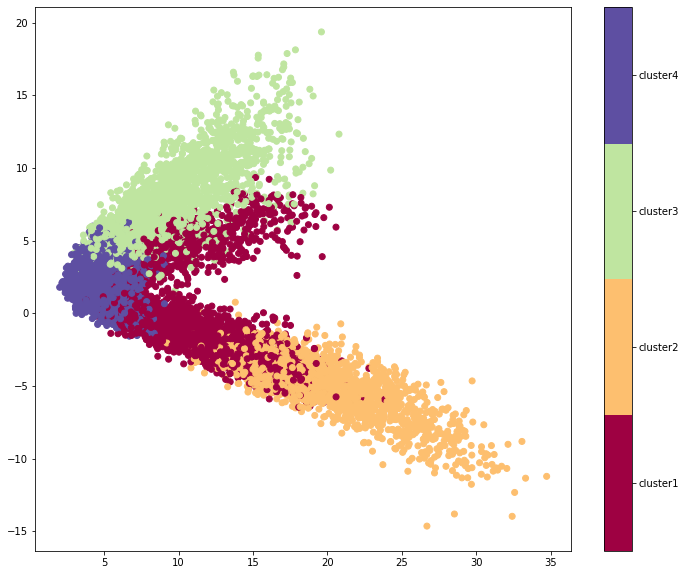

In [95]:
aggl_model = AgglomerativeClustering(n_clusters=4, linkage='ward')

aggl_all = aggl_model.fit_predict(data500D)
split = 0.8
n = int(len(aggl_all) * split)
aggl = aggl_all[:n].reshape(-1, 1)
aggl_test = aggl_all[n:].reshape(-1, 1)

#Plot the clusters
plt.figure(figsize=(12, 10))
plt.scatter(data2D[:, 0], data2D[:, 1], cmap=plt.cm.get_cmap('Spectral', 4), c=aggl_all)
cbar = plt.colorbar()
cbar.set_ticks([0.375, 1.125, 1.875, 2.625])
cbar.set_ticklabels(["cluster1", "cluster2", "cluster3", "cluster4"])

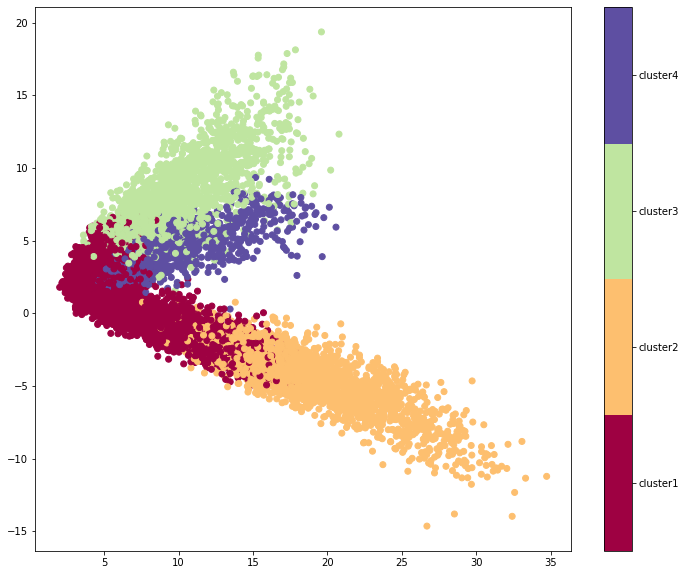

In [96]:
birch_model = Birch(threshold=0.4, n_clusters=4, branching_factor=20)

birch_all = birch_model.fit_predict(data500D)
split = 0.8
n = int(len(birch_all) * split)
birch = birch_all[:n].reshape(-1, 1)
birch_test = birch_all[n:].reshape(-1, 1)

#Plot the clusters
plt.figure(figsize=(12, 10))
plt.scatter(data2D[:, 0], data2D[:, 1], cmap=plt.cm.get_cmap('Spectral', 4), c=birch_all)
cbar = plt.colorbar()
cbar.set_ticks([0.375, 1.125, 1.875, 2.625])
cbar.set_ticklabels(["cluster1", "cluster2", "cluster3", "cluster4"])

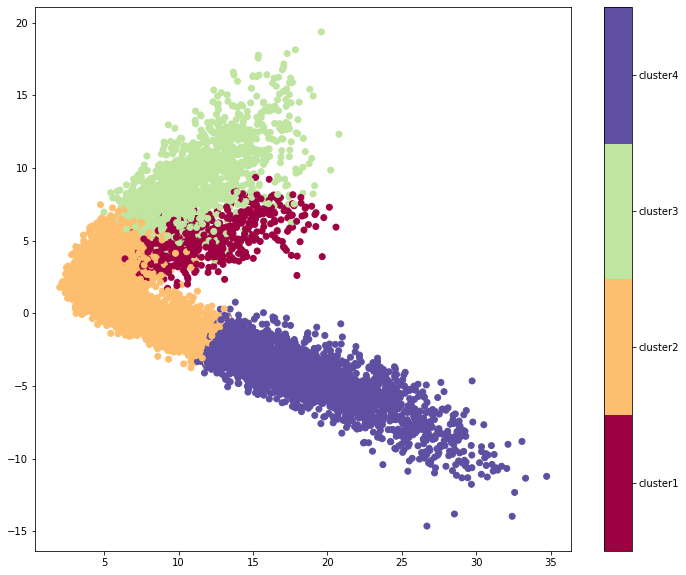

In [97]:
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=4)

kmeans_all = kmeans_model.fit_predict(data500D)
split = 0.8
n = int(len(kmeans_all) * split)
kmeans = kmeans_all[:n].reshape(-1, 1)
kmeans_test = kmeans_all[n:].reshape(-1, 1)

#Plot the clusters
plt.figure(figsize=(12, 10))
plt.scatter(data2D[:, 0], data2D[:, 1], cmap=plt.cm.get_cmap('Spectral', 4), c=kmeans_all)
cbar = plt.colorbar()
cbar.set_ticks([0.375, 1.125, 1.875, 2.625])
cbar.set_ticklabels(["cluster1", "cluster2", "cluster3", "cluster4"])

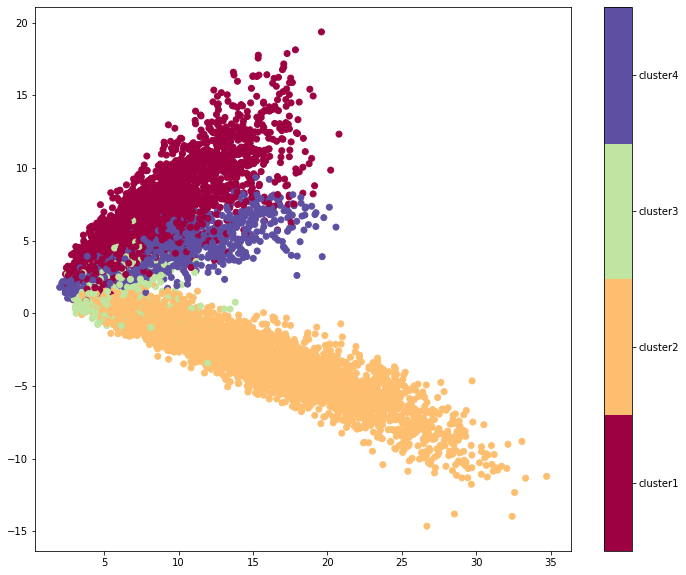

In [99]:
from sklearn.mixture import GaussianMixture
gm_model = GaussianMixture(n_components=4, covariance_type='full')

gm_all = gm_model.fit_predict(data500D)
split = 0.8
n = int(len(gm_all) * split)
gm = gm_all[:n].reshape(-1, 1)
gm_test = gm_all[n:].reshape(-1, 1)

#Plot the clusters
plt.figure(figsize=(12, 10))
plt.scatter(data2D[:, 0], data2D[:, 1], cmap=plt.cm.get_cmap('Spectral', 4), c=gm_all)
cbar = plt.colorbar()
cbar.set_ticks([0.375, 1.125, 1.875, 2.625])
cbar.set_ticklabels(["cluster1", "cluster2", "cluster3", "cluster4"])

In [100]:
# train-test split
split = 0.8
n = int(len(data500D) * split)
dim_train = data500D[:n]
dim_test = data500D[n:]

In [114]:
train2D = data2D[:n]
test2D = data2D[n:]

In [101]:
# combination of all clustering results
cluster_train = np.concatenate((aggl, birch, kmeans, gm), axis=1)
cluster_test = np.concatenate((aggl_test, birch_test, kmeans_test, gm_test), axis=1)

print(cluster_train.shape)

(7942, 4)


In [108]:
# combination of clustering and stat features
full_train = np.concatenate((cluster_train, dim_train), axis=1)
full_test = np.concatenate((cluster_test, dim_test), axis=1)

print(full_train.shape)

(7942, 504)


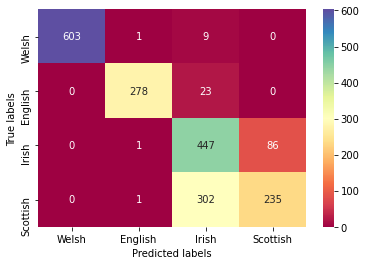

accuracy  0.7870090634441088
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       613
           1       0.99      0.92      0.96       301
           2       0.57      0.84      0.68       534
           3       0.73      0.44      0.55       538

    accuracy                           0.79      1986
   macro avg       0.82      0.80      0.79      1986
weighted avg       0.81      0.79      0.78      1986

MCC:  0.7240400617018882


In [117]:
# insert chosen training-testing sets

# SVM 
from sklearn.svm import SVC
svm = SVC(kernel='rbf', C=1, degree=4)
svm = svm.fit(cluster_train, train_target)
pred = svm.predict(cluster_test)

print_cm(test_target, pred)
acc = np.mean(pred == test_target)
print("accuracy ", acc)
print(classification_report(test_target, pred))
print('MCC: ', matthews_corrcoef(test_target, pred))

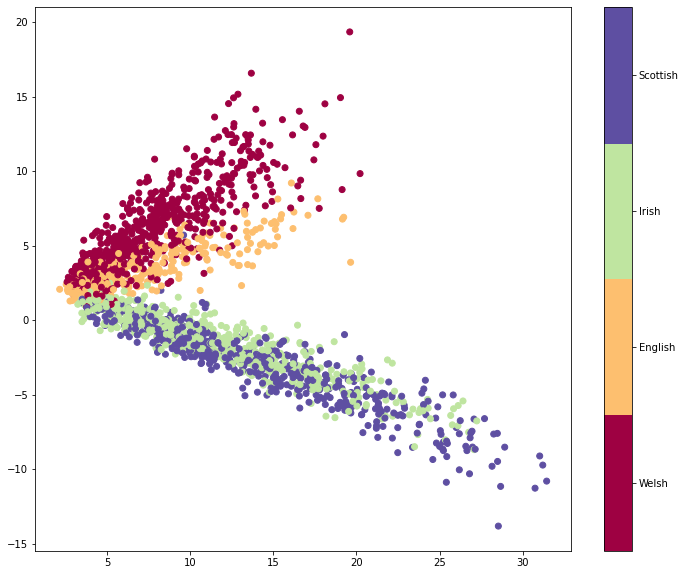

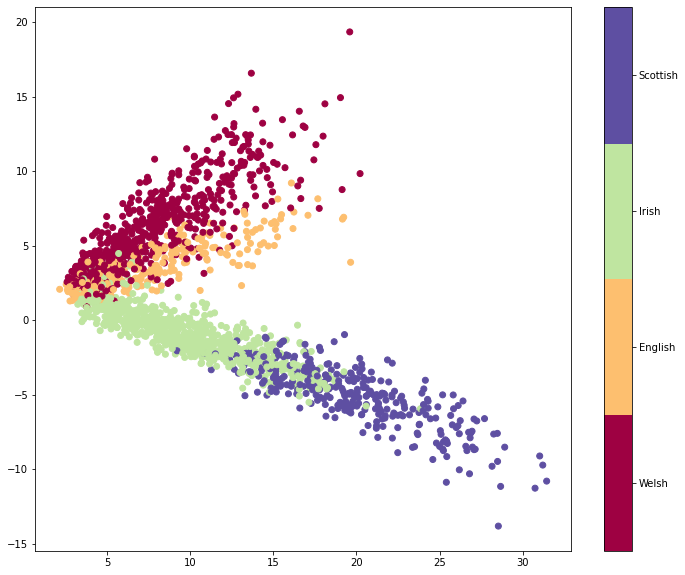

In [118]:
# test set true visualisation
plt.figure(figsize=(12, 10))
plt.scatter(test2D[:, 0], test2D[:, 1], cmap=plt.cm.get_cmap('Spectral', 4), c=test_target)
cbar = plt.colorbar()
cbar.set_ticks([0.375, 1.125, 1.875, 2.625])
cbar.set_ticklabels(["Welsh", "English", "Irish", "Scottish"])

# SVM results visualisation
plt.figure(figsize=(12, 10))
plt.scatter(test2D[:, 0], test2D[:, 1], cmap=plt.cm.get_cmap('Spectral', 4), c=pred)
cbar = plt.colorbar()
cbar.set_ticks([0.375, 1.125, 1.875, 2.625])
cbar.set_ticklabels(["Welsh", "English", "Irish", "Scottish"])

Epoch 1/20
50/50 [==============================] - 1s 7ms/step - loss: 0.7054 - acc: 0.6741 - val_loss: 0.4214 - val_acc: 0.7766
Epoch 2/20
50/50 [==============================] - 0s 4ms/step - loss: 0.4298 - acc: 0.7861 - val_loss: 0.4218 - val_acc: 0.7753
Epoch 3/20
50/50 [==============================] - 0s 4ms/step - loss: 0.4294 - acc: 0.7847 - val_loss: 0.4185 - val_acc: 0.7772
Epoch 4/20
50/50 [==============================] - 0s 4ms/step - loss: 0.4237 - acc: 0.7816 - val_loss: 0.4230 - val_acc: 0.7728
Epoch 5/20
50/50 [==============================] - 0s 4ms/step - loss: 0.4377 - acc: 0.7749 - val_loss: 0.4238 - val_acc: 0.7634
Epoch 6/20
50/50 [==============================] - 0s 3ms/step - loss: 0.4320 - acc: 0.7809 - val_loss: 0.4218 - val_acc: 0.7772
Epoch 7/20
50/50 [==============================] - 0s 4ms/step - loss: 0.4288 - acc: 0.7823 - val_loss: 0.4214 - val_acc: 0.7772
Epoch 8/20
50/50 [==============================] - 0s 4ms/step - loss: 0.4101 - acc: 0.79

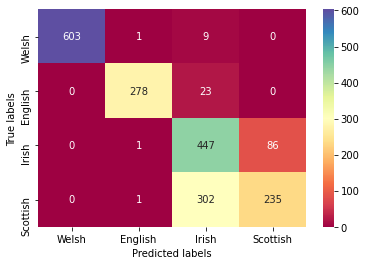

In [120]:
# FF 
from keras.layers import Dense, Input
from keras import Model
from keras.utils import to_categorical
from keras.optimizers import Adam

train_target_cat = to_categorical(train_target)
test_target_cat = to_categorical(test_target)

# insert chosen training-testing sets
ff_train = cluster_train
ff_test = cluster_test

inputs = Input(shape=(ff_train.shape[1],))
x = Dense(200, activation="relu")(inputs)
x = Dense(100, activation="relu")(x)
x = Dense(40, activation="relu")(x)
x = Dense(units=4, activation="softmax")(x)

model = Model(inputs, x)

adam = Adam(lr=0.01)
model.compile(optimizer=adam, loss="categorical_crossentropy", metrics=['acc'])
model.fit(ff_train, train_target_cat, batch_size=128, epochs=20, verbose=1, validation_split=0.2)

scores = model.evaluate(ff_test, test_target_cat, verbose=2)
print(scores)

y_pred = model.predict(ff_test)
y_norm = np.stack([to_categorical(np.asarray(x.argmax()), num_classes=4) for x in y_pred])
print(classification_report(test_target_cat, y_norm))
ff_pred = np.argmax(y_norm, axis=1)
print('MCC: ', matthews_corrcoef(test_target, ff_pred))
print("classes: 0-cy, 1-en, 2-ga, 3-gd")
print_cm(test_target, ff_pred)

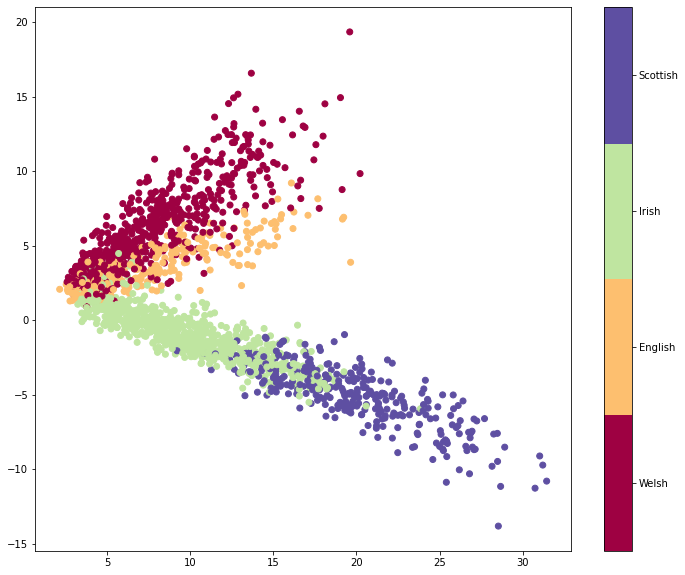

In [121]:
# ff test set results visualisation
plt.figure(figsize=(12, 10))
plt.scatter(test2D[:, 0], test2D[:, 1], cmap=plt.cm.get_cmap('Spectral', 4), c=ff_pred)
cbar = plt.colorbar()
cbar.set_ticks([0.375, 1.125, 1.875, 2.625])
cbar.set_ticklabels(["Welsh", "English", "Irish", "Scottish"])